In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')
import xgboost

In [6]:
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')

In [7]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [8]:
df_train["SalePrice"].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.19589,79442.502883,34900.0,129975.0,163000.0,214000.0,755000.0


In [9]:
y = df_train['SalePrice']

In [10]:
df_train.drop('SalePrice', axis=1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


Text(0.5, 1.0, 'SalePrice Distribution Plot')

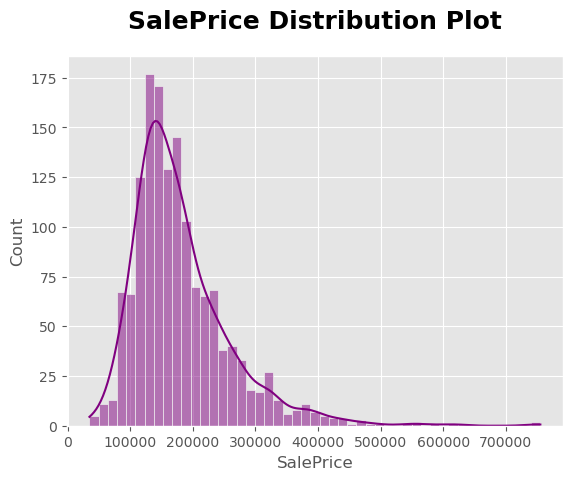

In [11]:
sns.histplot(df_train["SalePrice"],color="purple",kde=True)
plt.title("SalePrice Distribution Plot",fontweight="black",pad=20,size=18)

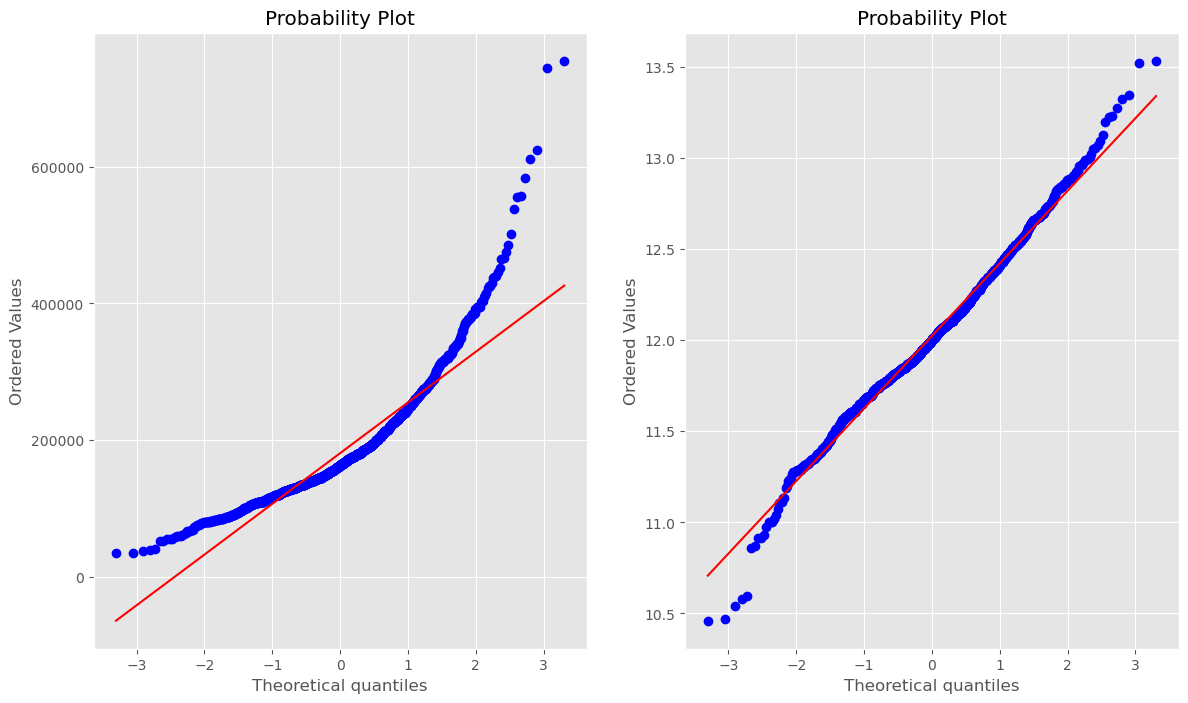

In [12]:
# ассиметрия большая, поэтому делаем логарифмическое преобразование
fig = plt.figure(figsize = (14,8))

# Распределение на необработанных данных
fig.add_subplot(1,2,1)
res = stats.probplot(df_train['SalePrice'], plot=plt)

# Распределение при условии, что мы прологарифмировали 'SalePrice'
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['SalePrice']), plot=plt)

In [13]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

### Columns with Nan values

In [14]:
df_train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

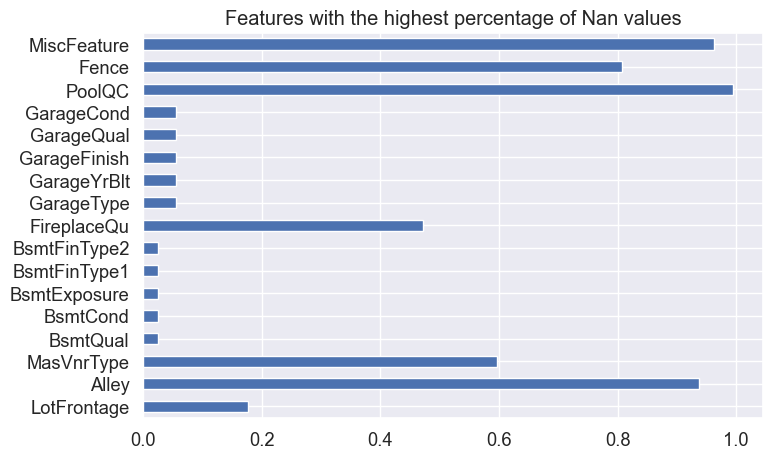

In [15]:
col_nan = df_train.isna().sum() / df_train.shape[0]
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

In [16]:
drop_out_columns = df_train.columns[[inx for inx, i in enumerate(col_nan >= 0.80) if i==True]]
data_df = df_train.drop(drop_out_columns, axis=1)
test_df = df_test.drop(drop_out_columns, axis=1)

In [17]:
data_df.isnull().sum().sort_values(ascending=False).head(20)

MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageCond       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageType       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
Electrical        1
BsmtFullBath      0
Functional        0
TotRmsAbvGrd      0
GrLivArea         0
HalfBath          0
dtype: int64

In [32]:
# data_df = data_df.drop(["Street", "Utilities", "Id"], axis=1)
# test_df = test_df.drop(["Street", "Utilities", "Id"], axis=1)
data_df.shape, test_df.shape

((1460, 74), (1459, 73))

### Concat data

In [19]:
df = pd.concat([data_df, test_df],)
print("Shape of df: ", df.shape)

Shape of df:  (2919, 74)


### Imputing data

In [20]:
numerical_features=[]
for feature in df:
    if df[feature].dtype!='O' and feature!= 'SalePrice':
        numerical_features.append(feature)

object_features= []
for feature in df:
    if df[feature].dtype =='object' and feature!= 'SalePrice':
        object_features.append(feature)


discrete_variables=[]
for feature in numerical_features:
    if len(df[feature].unique())<=25 and feature != 'SalePrice':
        discrete_variables.append(feature)

print(np.array(numerical_features))

['MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold']


In [21]:
# Разбираемся с пропущенными данными
# Числовые значения отбираем через принадлежность к формату ['int64', 'float64']
# Категориальные значения отбираем через принадлежность к формату ["object"]

def HandleMissingValues(df):
    num_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
    cat_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
    values = {}
    for a in cat_cols:
        values[a] = df[a].mode()

    for a in num_cols:
        values[a] = df[a].median()
        
    df.fillna(value=values, inplace=True)
    
    
HandleMissingValues(df)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,0,0,0,0,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,0,0,0,0,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,0,0,0,0,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,0,0,0,0,0,12,2008,WD,Normal,12.429220


In [22]:
df.isnull().sum().sum()

4232

In [23]:
df.isnull().sum().sort_values(ascending=False).head(20)

MasVnrType      1765
FireplaceQu     1418
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MSZoning           4
Functional         2
SaleType           1
KitchenQual        1
Exterior1st        1
Exterior2nd        1
Electrical         1
Fireplaces         0
TotRmsAbvGrd       0
dtype: int64

In [24]:
def getObjectColumnsList(df):
    return [cname for cname in df.columns if df[cname].dtype == "object"]

def PerformOneHotEncoding(df, columnsToEncode):
    return pd.get_dummies(df, columns=columnsToEncode)

cat_cols = getObjectColumnsList(df)
df = PerformOneHotEncoding(df, cat_cols)
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,False,True,False,False,False,False,True,False


In [25]:

cols = df.select_dtypes(np.number).columns
df[cols] = RobustScaler().fit_transform(df[cols])

In [26]:
data_inc = pd.get_dummies(df) #Get_dummies function to encode data

In [27]:
data_inc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Columns: 271 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(234), float64(37)
memory usage: 1.5 MB


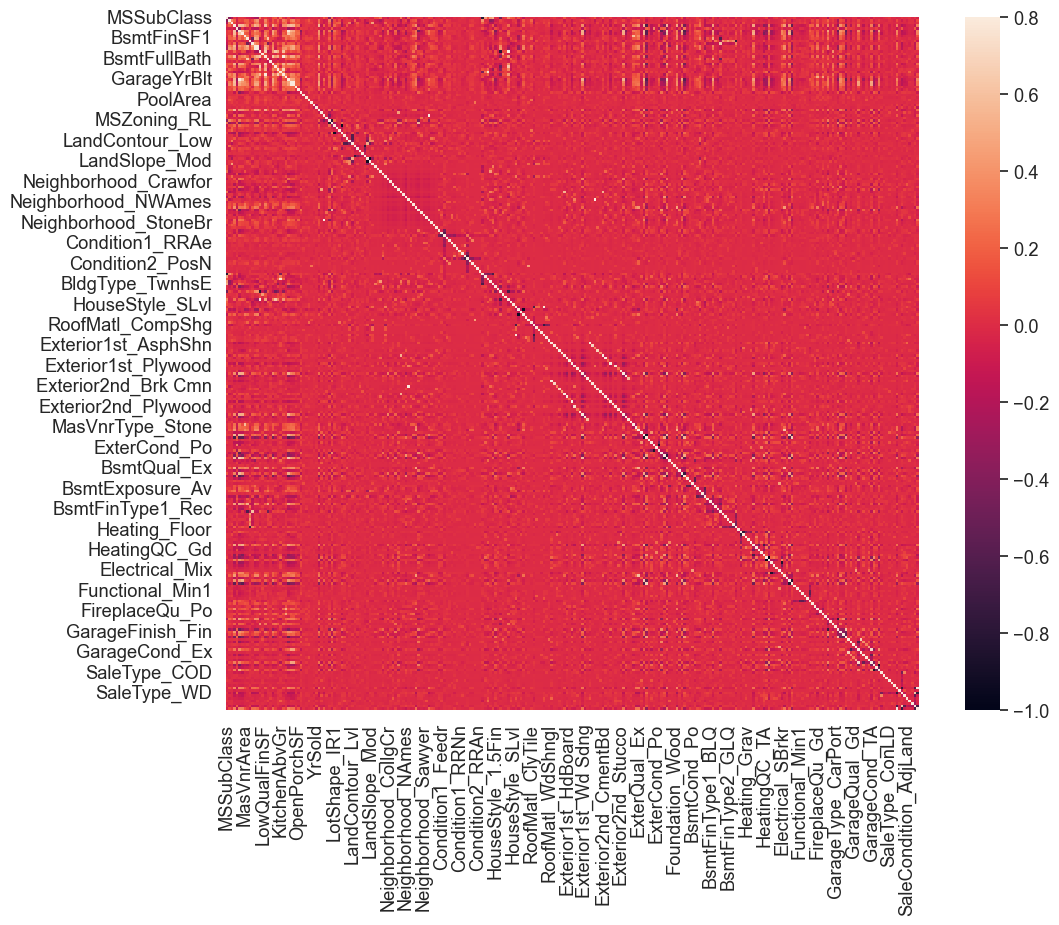

In [28]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

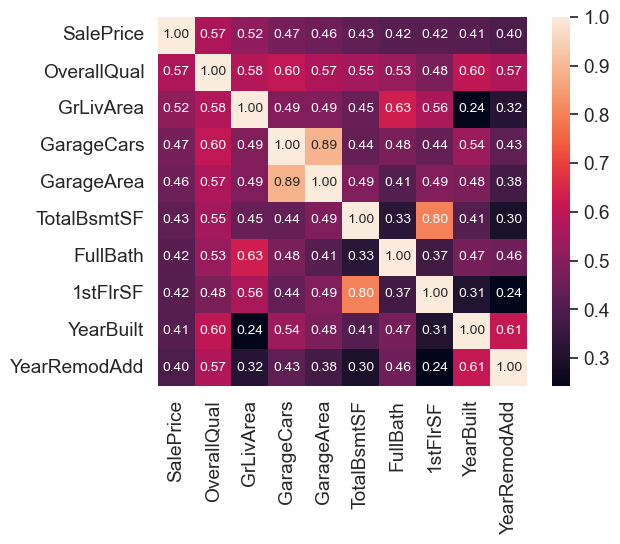

In [29]:
k = 10 # количество коррелирующих признаков, которое мы хотим увидеть
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [30]:
df.shape

(2919, 271)